# Load Dataset

In [1]:
from flaxfm.utils import config, time_measure
from flaxfm.dataset.movielens import MovieLens20MDataset
import torch
from torch.utils.data import DataLoader

dataset = MovieLens20MDataset(dataset_path='/dist/dataset/ratings.csv')

train_length = int(len(dataset) * 0.8)
valid_length = int(len(dataset) * 0.1)
test_length = len(dataset) - train_length - valid_length
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(
        dataset, (train_length, valid_length, test_length))

train_data_loader = DataLoader(train_dataset, batch_size=config.batch_size, num_workers=4)
valid_data_loader = DataLoader(valid_dataset, batch_size=config.batch_size, num_workers=4)
test_data_loader = DataLoader(test_dataset, batch_size=config.batch_size, num_workers=4)

data_loader_dict = {}
data_loader_dict['train'] = train_data_loader
data_loader_dict['valid'] = valid_data_loader
data_loader_dict['test'] = test_data_loader

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Export Pytorch model as onnx file

In [2]:
import numpy as np
class FeaturesLinear(torch.nn.Module):

    def __init__(self, field_dims, output_dim=1):
        super().__init__()
        self.fc = torch.nn.Embedding(sum(field_dims), output_dim)
        self.bias = torch.nn.Parameter(torch.zeros((output_dim,)))
        self.offsets = np.array((0, *np.cumsum(field_dims)[:-1]), dtype=np.compat.long)

    def forward(self, x):
        """
        :param x: Long tensor of size ``(batch_size, num_fields)``
        """
        d = x.new_tensor(self.offsets).unsqueeze(0)
        x = x + x.new_tensor(self.offsets).unsqueeze(0)
        return torch.sum(self.fc(x), dim=1) + self.bias


class FeaturesEmbedding(torch.nn.Module):

    def __init__(self, field_dims, embed_dim=16):
        super().__init__()
        self.embedding = torch.nn.Embedding(sum(field_dims), embed_dim)
        self.offsets = np.array((0, *np.cumsum(field_dims)[:-1]), dtype=np.compat.long)
        torch.nn.init.xavier_uniform_(self.embedding.weight.data)

    def forward(self, x):
        """
        :param x: Long tensor of size ``(batch_size, num_fields)``
        """
        x = x + x.new_tensor(self.offsets).unsqueeze(0)
        return self.embedding(x)

class FactorizationMachine(torch.nn.Module):

    def __init__(self, reduce_sum=True):
        super().__init__()
        self.reduce_sum = reduce_sum

    def forward(self, x):
        """
        :param x: Float tensor of size ``(batch_size, num_fields, embed_dim)``
        """
        square_of_sum = torch.sum(x, dim=1) ** 2
        sum_of_square = torch.sum(x ** 2, dim=1)
        ix = square_of_sum - sum_of_square
        if self.reduce_sum:
            ix = torch.sum(ix, dim=1, keepdim=True)
        return 0.5 * ix


class FactorizationMachineModel(torch.nn.Module):
    """
    A pytorch implementation of Factorization Machine.
    Reference:
        S Rendle, Factorization Machines, 2010.
    """

    def __init__(self, field_dims, embed_dim):
        super().__init__()
        self.embedding = FeaturesEmbedding(field_dims, embed_dim)
        self.linear = FeaturesLinear(field_dims)
        self.fm = FactorizationMachine(reduce_sum=True)

    def forward(self, x):
        """
        :param x: Long tensor of size ``(batch_size, num_fields)``
        """
        x = self.linear(x) + self.fm(self.embedding(x))
        return torch.sigmoid(x.squeeze(1))

In [3]:
from torch import nn
import torch.onnx
x_train = next(train_data_loader.__iter__())[0].numpy()
net = FactorizationMachineModel(dataset.field_dims, 16)
params = net.state_dict()
dummy_data = torch.tensor(x_train, dtype=torch.int64)
torch.onnx.export(net, dummy_data, "FactorizationMachineModel_Pytorch_model.onnx")


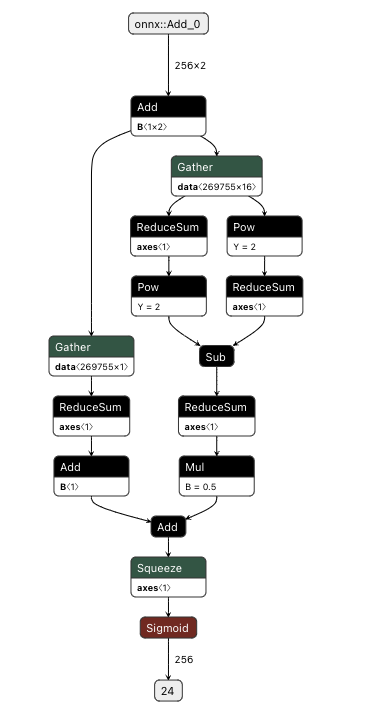

In [5]:
from IPython.display import Image
Image('./img/FactorizationMachineModel_Pytorch_onnx.png')

# Export model written in Flax as Tensorflow lite model

* jax 기반으로 작성된 코드를 tensorflow로 변환합니다. onnx로 직접 변환하는 기능은 현재 존재하지 않는 것으로 파악됩니다.(2023/01/18)
* 링크 : https://github.com/google/jax/tree/main/jax/experimental/jax2tf

In [6]:
from flaxfm.model.fm import FactorizationMachineModelFlax
import jax

# Define the model using FactorizationMachineModelFlax
embed_dim = 16
model = FactorizationMachineModelFlax(dataset.field_dims, embed_dim)
rng = jax.random.PRNGKey(0)
init_params = model.init(rng, next(train_data_loader.__iter__())[0].numpy())['params']

In [7]:
x_train = next(train_data_loader.__iter__())[0].numpy()

predict_fn = lambda x : model.apply({'params':init_params}, x)

In [8]:
import tensorflow as tf
from jax.experimental import jax2tf
import os

tf_predict = tf.function(
    jax2tf.convert(predict_fn, enable_xla=False),
    input_signature=[
        tf.TensorSpec(
            shape=x_train.shape,
            dtype=tf.int64,
            name='input')],
    autograph=False)

2023-01-18 18:47:36.135011: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-01-18 18:47:36.135107: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-01-18 18:47:36.135116: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [9]:
converter = tf.lite.TFLiteConverter.from_concrete_functions([tf_predict.get_concrete_function()], tf_predict)

In [10]:
tflite_model = converter.convert()
# Save the model

with open(os.path.join('./', 'FactorizationMachineModelFlax.tflite'), 'wb') as f:
    f.write(tflite_model)


2023-01-18 18:47:55.359650: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-01-18 18:47:55.359683: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.


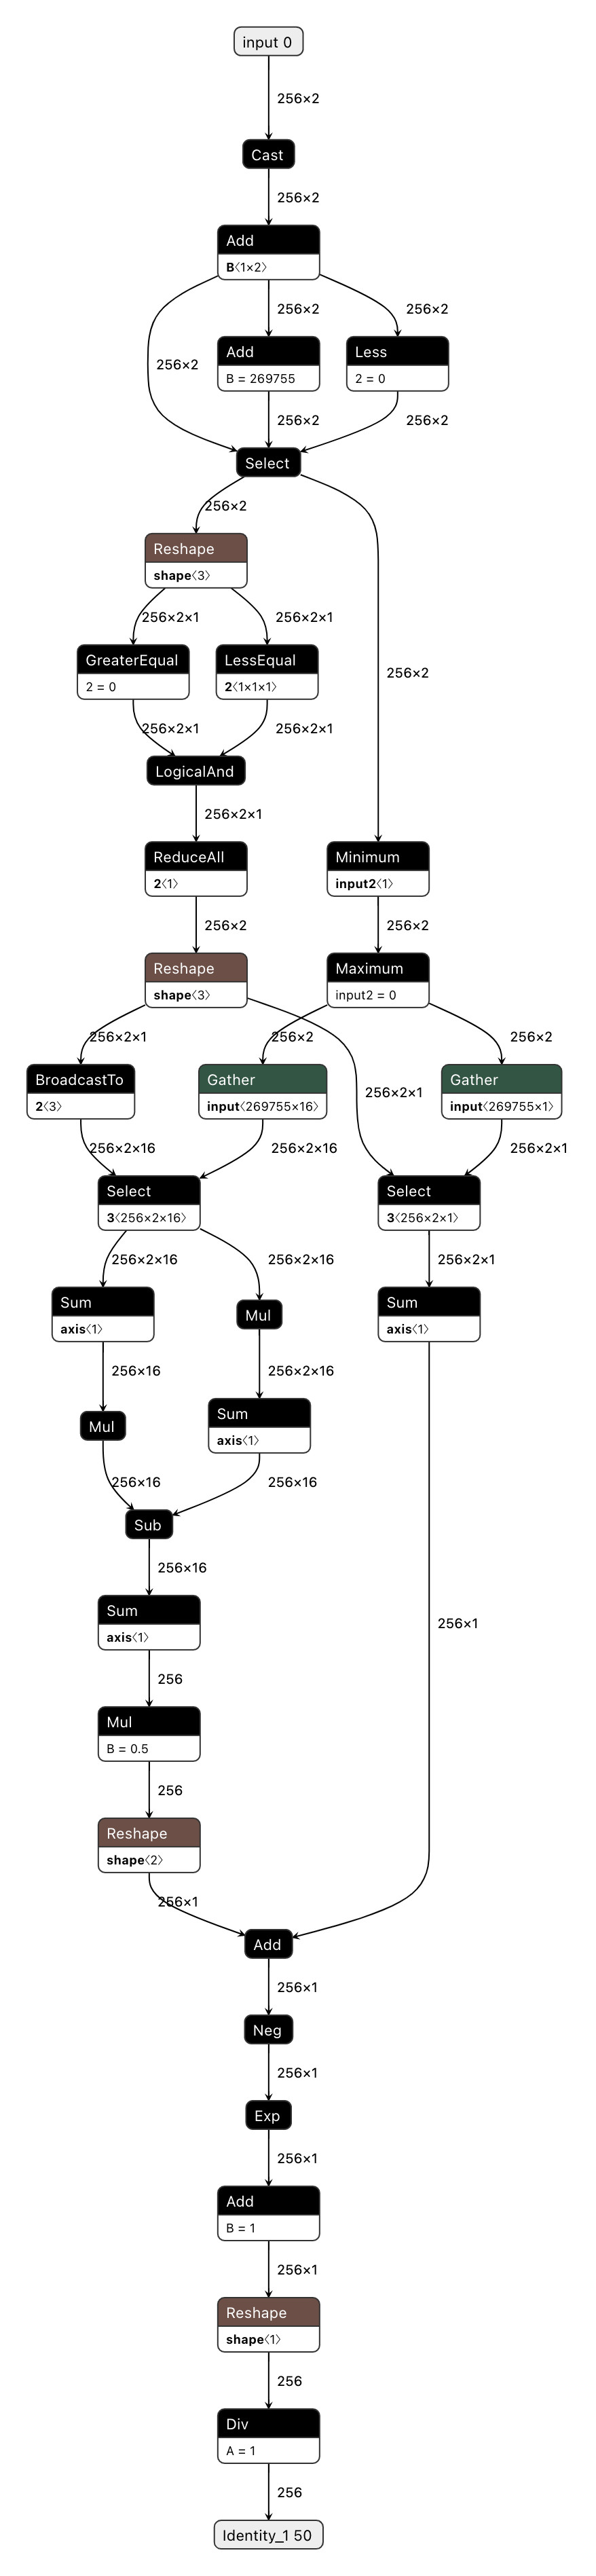

In [11]:
from IPython.display import Image
Image('./img/FactorizationMachineModelFlax_tflite.png')